In [89]:
class Dubins:
    def __init__(self, radius, point_separation):
        assert radius > 0 and point_separation > 0
        self.radius = radius
        self.point_separation = point_separation

    def all_options(self, start, end, sort=False):
        center_0_left = self.find_center(start, 'L')
        center_0_right = self.find_center(start, 'R')
        center_2_left = self.find_center(end, 'L')
        center_2_right = self.find_center(end, 'R')
        options = [self.lsl(start, end, center_0_left, center_2_left),
                   self.rsr(start, end, center_0_right, center_2_right),
                   self.rsl(start, end, center_0_right, center_2_left),
                   self.lsr(start, end, center_0_left, center_2_right),
                   self.rlr(start, end, center_0_right, center_2_right),
                   self.lrl(start, end, center_0_left, center_2_left)]
        if sort:
            options.sort(key=lambda x: x[0])
        return options

    def dubins_path(self, start, end):
        options = self.all_options(start, end)
        dist, dubins_path, straight = min(options, key=lambda x: x[0])
        return self.generate_points(start, end, dubins_path, False), dist

    def generate_points(self, start, end, dubins_path, straight):
        if straight:
            return self.generate_points_straight(start, end, dubins_path)
        return self.generate_points_curve(start, end, dubins_path)

    def lsl(self, start, end, center_0, center_2):
        straight_dist = dist(center_0, center_2)
        alpha = np.arctan2((center_2 - center_0)[1], (center_2 - center_0)[0])
        beta_2 = (end[2] - alpha) % (2 * np.pi)
        beta_0 = (alpha - start[2]) % (2 * np.pi)
        total_len = self.radius * (beta_2 + beta_0) + straight_dist
        return (total_len, (beta_0, beta_2, straight_dist), True)

    def rsr(self, start, end, center_0, center_2):
        straight_dist = dist(center_0, center_2)
        alpha = np.arctan2((center_2 - center_0)[1], (center_2 - center_0)[0])
        beta_2 = (-end[2] + alpha) % (2 * np.pi)
        beta_0 = (-alpha + start[2]) % (2 * np.pi)
        total_len = self.radius * (beta_2 + beta_0) + straight_dist
        return (total_len, (-beta_0, -beta_2, straight_dist), True)

    def rsl(self, start, end, center_0, center_2):
        median_point = (center_2 - center_0) / 2
        psia = np.arctan2(median_point[1], median_point[0])
        half_intercenter = np.linalg.norm(median_point)
        if half_intercenter < self.radius:
            return (float('inf'), (0, 0, 0), True)
        alpha = np.arccos(self.radius / half_intercenter)
        beta_0 = -(psia + alpha - start[2] - np.pi / 2) % (2 * np.pi)
        beta_2 = (np.pi + end[2] - np.pi / 2 - alpha - psia) % (2 * np.pi)
        straight_dist = 2 * (half_intercenter ** 2 - self.radius ** 2) ** .5
        total_len = self.radius * (beta_2 + beta_0) + straight_dist
        return (total_len, (-beta_0, beta_2, straight_dist), True)

    def lsr(self, start, end, center_0, center_2):
        median_point = (center_2 - center_0) / 2
        psia = np.arctan2(median_point[1], median_point[0])
        half_intercenter = np.linalg.norm(median_point)
        if half_intercenter < self.radius:
            return (float('inf'), (0, 0, 0), True)
        alpha = np.arccos(self.radius / half_intercenter)
        beta_0 = (psia - alpha - start[2] + np.pi / 2) % (2 * np.pi)
        beta_2 = (.5 * np.pi - end[2] - alpha + psia) % (2 * np.pi)
        straight_dist = 2 * (half_intercenter ** 2 - self.radius ** 2) ** .5
        total_len = self.radius * (beta_2 + beta_0) + straight_dist
        return (total_len, (beta_0, -beta_2, straight_dist), True)

    def lrl(self, start, end, center_0, center_2):
        dist_intercenter = dist(center_0, center_2)
        intercenter = (center_2 - center_0) / 2
        psia = np.arctan2(intercenter[1], intercenter[0])
        if 2 * self.radius < dist_intercenter > 4 * self.radius:
            return (float('inf'), (0, 0, 0), False)
        gamma = 2 * np.arcsin(dist_intercenter / (4 * self.radius))
        beta_0 = (psia - start[2] + np.pi / 2 + (np.pi - gamma) / 2) % (2 * np.pi)
        beta_1 = (-psia + np.pi / 2 + end[2] + (np.pi - gamma) / 2) % (2 * np.pi)
        total_len = (2 * np.pi - gamma + abs(beta_0) + abs(beta_1)) * self.radius
        return (total_len, (beta_0, beta_1, 2 * np.pi - gamma), False)

    def rlr(self, start, end, center_0, center_2):
        dist_intercenter = dist(center_0, center_2)
        intercenter = (center_2 - center_0) / 2
        psia = np.arctan2(intercenter[1], intercenter[0])
        if 2 * self.radius < dist_intercenter > 4 * self.radius:
            return (float('inf'), (0, 0, 0), False)
        gamma = 2 * np.arcsin(dist_intercenter / (4 * self.radius))
        beta_0 = -((-psia + (start[2] + np.pi / 2) + (np.pi - gamma) / 2) % (2 * np.pi))
        beta_1 = -((psia + np.pi / 2 - end[2] + (np.pi - gamma) / 2) % (2 * np.pi))
        total_len = (2 * np.pi - gamma + abs(beta_0) + abs(beta_1)) * self.radius
        return (total_len, (beta_0, beta_1, 2 * np.pi - gamma), False)

    def find_center(self, ref, orientation):
        # orientation %= 2 * np.pi
        displacement = ortho(np.array([np.cos(ref[2]), np.sin(ref[2])]))
        displacement /= np.linalg.norm(displacement)
        displacement *= self.radius
        if orientation == 'L':
            return displacement + ref[:2]
        return -displacement + ref[:2]

    def generate_points_straight(self, start, end, dubins_path):
        beta_0, beta_2, straight_dist = dubins_path
        result = []
        center_0 = self.find_center(start, 'L')
        center_2 = self.find_center(end, 'L')
        circ_start = np.array(center_0) + self.radius * np.array([np.cos(start[2] + beta_0), np.sin(start[2] + beta_0)])
        circ_end = np.array(center_2) + self.radius * np.array([np.cos(end[2] - beta_2), np.sin(end[2] - beta_2)])
        linear_path = np.linspace(circ_start, circ_end, int(straight_dist / self.point_separation))
        result.append(start[:2])
        result.extend(linear_path.tolist())
        result.append(end[:2])
        return result

    def generate_points_curve(self, start, end, dubins_path):
          beta_0, beta_1, beta_2 = dubins_path
          result = []
          center_0 = self.find_center(start, 'L')
          center_2 = self.find_center(end, 'L')
          circ_start = np.array(center_0) + self.radius * np.array([np.cos(start[2] + beta_0), np.sin(start[2] + beta_0)])
          circ_end = np.array(center_2) + self.radius * np.array([np.cos(end[2] - beta_2), np.sin(end[2] - beta_2)])
          num_samples = max(int(abs(beta_1) / self.point_separation), 1)  # Ensure non-negative number of samples
          linear_path = np.linspace(circ_start, circ_end, num_samples)
          result.append(start[:2])
          result.extend(linear_path.tolist())
          result.append(end[:2])
          return result

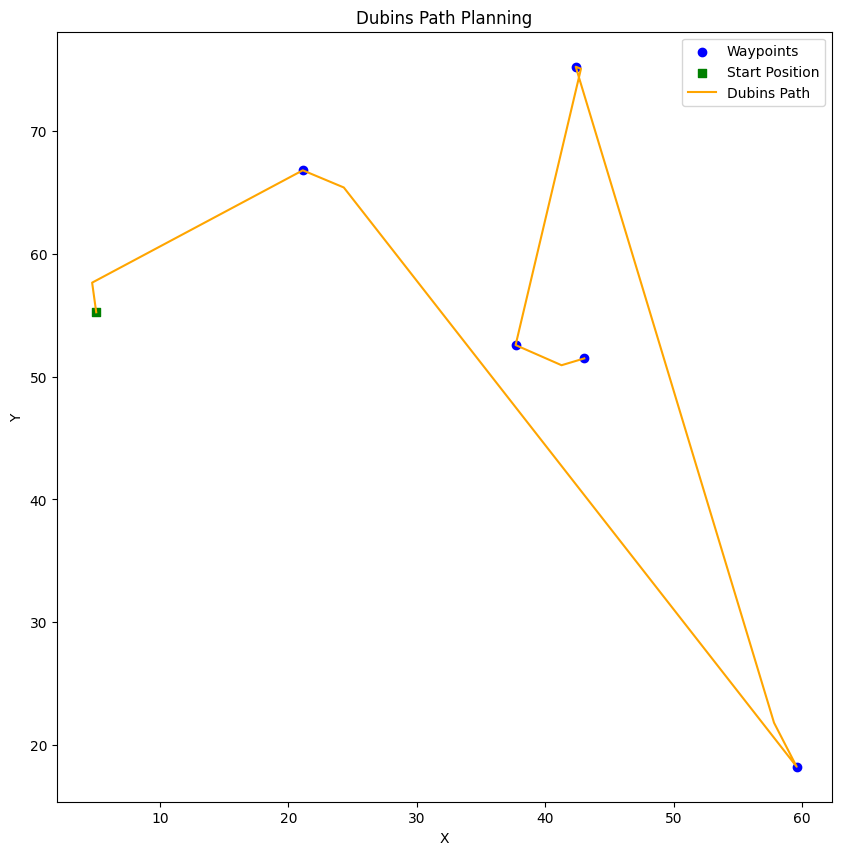

Path Length: 172.4174472317118


In [93]:
import numpy as np
import matplotlib.pyplot as plt

class WaypointGenerator:
    def __init__(self, num_points, area_size, cluster_percentage, cluster_std):
        self.num_points = num_points
        self.area_size = area_size
        self.cluster_percentage = cluster_percentage
        self.cluster_std = cluster_std
        self.waypoints = None
        self.robot_start_pos = None

    def generate_random_points(self):
        self.waypoints = np.random.uniform(0, self.area_size, (self.num_points, 2))

    def add_clusters(self):
        num_clusters = int(self.num_points * self.cluster_percentage)
        cluster_indices = np.random.choice(range(self.num_points), num_clusters, replace=False)

        for idx in cluster_indices:
            num_plants = np.random.randint(2, 10)
            cluster_center = self.waypoints[idx]
            plants_x = np.random.normal(cluster_center[0], self.cluster_std, num_plants)
            plants_y = np.random.normal(cluster_center[1], self.cluster_std, num_plants)
            cluster_points = np.column_stack((plants_x, plants_y))
            self.waypoints = np.concatenate((self.waypoints, cluster_points))

    def assign_start_position(self):
        self.robot_start_pos = np.random.uniform(0, self.area_size, 2)

# Define the Dubins path functions
def ortho(vect2d):
    return np.array((-vect2d[1], vect2d[0]))

def dist(pt_a, pt_b):
    return ((pt_a[0] - pt_b[0]) ** 2 + (pt_a[1] - pt_b[1]) ** 2) ** .5

def plot_points(points, clusters, start_pos, path):
    plt.figure(figsize=(10, 10))
    plt.scatter(points[:, 0], points[:, 1], c='blue', marker='o', label='Waypoints')
    # plt.scatter(clusters[:, 0], clusters[:, 1], c='red', marker='x', label='Cluster Points')
    plt.scatter(start_pos[0], start_pos[1], c='green', marker='s', label='Start Position')
    path = np.array(path)
    plt.plot(path[:, 0], path[:, 1], c='orange', label='Dubins Path')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.title('Dubins Path Planning')
    plt.show()


def calculate_path_length(path):
    length = 0.0
    for i in range(1, len(path)):
        length += dist(path[i-1], path[i])
    return length

def main():
    num_points = 5
    area_size = 100
    cluster_percentage = 0.5
    cluster_std = 3

    generator = WaypointGenerator(num_points, area_size, cluster_percentage, cluster_std)
    generator.generate_random_points()
    generator.add_clusters()
    generator.assign_start_position()

    all_points = generator.waypoints
    clusters = all_points[num_points:]  # Separate cluster points
    points = all_points[:num_points]  # Original points
    start_pos = generator.robot_start_pos

    start = np.append(start_pos, np.random.uniform(0, 2 * np.pi))
    waypoints = [np.append(point, np.random.uniform(0, 2 * np.pi)) for point in points]

    dubins = Dubins(radius=2, point_separation=2)
    path = []
    current_pos = start

    for waypoint in waypoints:
        new_path, _ = dubins.dubins_path(current_pos, waypoint)
        path.extend(new_path)
        current_pos = waypoint

    plot_points(points, clusters, start_pos, path)
    path_length = calculate_path_length(path)
    print("Path Length:", path_length)

if __name__ == "__main__":
    main()
